In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp

import appletree as apt
from appletree import randgen
from appletree import Parameter
from appletree.components import *

In [2]:
apt.set_gpu_memory_usage(0.2)

# Define parameters

In [3]:
par_config_file_name = '/home/zihaoxu/appletree/appletree/parameters/apt_sr0_er.json'
par_manager = Parameter(par_config_file_name)

# Equiprob data hist

In [4]:
data = pd.read_csv('./appletree/data/data_XENONnT_Rn220_v8_strax_v1.2.2_straxen_v1.7.1_cutax_v1.9.0.csv')

bins_cs1, bins_cs2 = apt.utils.get_equiprob_bins_2d(
    data[['cs1', 'cs2']].to_numpy(),
    [15, 15],
    order=[0, 1],
    x_clip=[0, 100],
    y_clip=[4e2, 1e4],
    which_np=jnp
)

In [5]:
data_hist = apt.hist.make_hist_irreg_bin_2d(data[['cs1', 'cs2']].to_numpy(), bins_cs1, bins_cs2, weights=jnp.ones(len(data)))

# Define component

In [6]:
observables = ['cs1', 'cs2']

In [7]:
er = ERBand()
er.deduce(
    data_names = observables + ['eff'],
    func_name = 'er_sim',
    bins = [bins_cs1, bins_cs2],
    bins_type = 'irreg'
)
er.compile()

In [8]:
ac = AC()
ac.deduce(
    data_names = observables,
    bins = [bins_cs1, bins_cs2],
    bins_type = 'irreg'
)
ac.compile()

# Define posterior

In [10]:
def log_posterior(pars, batch_size=int(1e6)):
    par_manager.set_parameter_fit_from_array(pars)
    parameters = par_manager.get_all_parameter()
    
    key = randgen.get_key()
    key, er_hist = er.simulate_hist(key, batch_size, parameters)
    ac_hist = ac.simulate_hist(parameters)
    model_hist = er_hist + ac_hist
    
    log_likelihood = float(jnp.sum(data_hist * jnp.log(model_hist) - model_hist))
    log_prior = par_manager.log_prior
    
    # This check is required. Consider a non-sensible parameter which
    # has -np.inf prior, and could have np.nan likelihood, then the
    # prior would be -np.inf + np.nan = np.nan
    if np.isnan(log_likelihood + log_prior):
        return -np.inf
    
    return log_likelihood + log_prior

# Fit

In [13]:
import emcee

In [14]:
nwalkers = 200
ndim = len(par_manager.parameter_fit_array)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

p0 = []
for _ in range(nwalkers):
    par_manager.sample_init()
    p0.append(par_manager.parameter_fit_array)
    
_ = sampler.run_mcmc(p0, 500, progress=True)

 14%|█▍        | 71/500 [02:04<12:35,  1.76s/it]Traceback (most recent call last):
  File "/home/zihaoxu/.local/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_2438074/2858313472.py", line 10, in log_posterior
    log_likelihood = float(jnp.sum(data_hist * jnp.log(model_hist) - model_hist))
  File "/home/zihaoxu/.local/lib/python3.8/site-packages/jax/_src/device_array.py", line 296, in <lambda>
    setattr(device_array, "__float__", lambda self: self._value.__float__())
KeyboardInterrupt
 14%|█▍        | 71/500 [02:05<12:38,  1.77s/it]

emcee: Exception while calling your likelihood function:
  params: [ 1.35475609e-02  1.11820870e-01  1.49962880e-01  1.62399855e+01
  2.23058263e-01  1.29262789e-01  4.40947397e+01 -3.13343452e-01
  1.25523575e+00  5.59294849e-01  3.24341160e-02  1.99717784e-01
  1.19512459e+01  2.00709158e+03]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

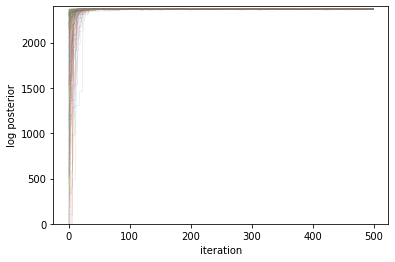

In [11]:
logp = sampler.get_log_prob()

for _logp in logp.T:
    plt.plot(_logp, lw=0.1)

plt.ylim(0, 2400)
plt.xlabel('iteration')
plt.ylabel('log posterior')
plt.show()